<a href="https://colab.research.google.com/github/morwald/ada_project/blob/master/gender_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gender distribution in UK's leading newspapers
# Gender representation

## Content
1. [Setup](#setup)   
    1.1 [Global](#global_setup)  
    1.2 [Local](#local_setup)

## 1. Setup
<a id="setup"></a>

### 1.1 Global
<a id="global_setup"></a>

In [1]:
# Change to true if you want to use google colab
use_colab = True

# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    %cd /content/drive/Shareddrives/ADA-project
    #!pip install pandas==1.0.5 # downgrade pandas for chunk processing support

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


In [2]:
# Defined paths for the data
from scripts.path_defs import *

# Defined newspapers and urls
from scripts.newspapers import *

# Globally used functions
from scripts.utility_functions import load_mini_version_of_data
from scripts.utility_functions import convert_to_1Dseries
from scripts.utility_functions import process_data_in_chunks

# Functions and libraries to perform topic analysis
from collections import Counter
from functools import reduce

### 1.2 Local 
<a id="local_setup"></a>

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2
import plotly.graph_objects as go
import plotly.express as px

## Topic analysis set up with empath

TODO : Intro on empath, which year, what it does, why we use it

In [4]:
! pip install empath

     |████████████████████████████████| 57 kB 2.8 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=7ca7c9fc781ada7830ecb9261f7ce5525069b58c6eb0973e871a1f41179b70e2
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath


In [5]:
from empath import Empath

# Define lexicon
lexicon = Empath()

In [6]:
# Creation of a category me-too to describe better the feminism event of the last few years
lexicon.create_category("metoo",["metoo","#metoo","consent", "harassment", "sexual assault", "sexual misconduct"], model='nytimes')

["harassment", "consent", "coercion", "notification", "legal_rights", "due_process", "criminal_prosecution", "constitutional_rights", "such_conduct", "abuse", "unlawful", "court_orders", "confidentiality", "sexual_harassment", "illegal_activity", "criminal_proceedings", "misconduct", "violation", "sexual_activity", "sexual_relations", "conduct", "rape_victims", "sanction", "criminal_conduct", "sexual_contact", "recourse", "injunctions", "discrimination", "sexual_orientation", "intimidation", "criminal_activity", "such_practices", "sexual_conduct", "criminal_prosecutions", "mistreatment", "the_Fourth_Amendment", "illegality", "civil_authorities", "sex_discrimination", "federal_laws", "reasonable_suspicion", "disciplinary_actions", "Florida_law", "Miranda_warnings", "complainants", "immigration_status", "privacy_rights", "political_beliefs", "racial_discrimination", "noncompliance", "sex_crimes", "homosexual_conduct", "sexual_intercourse", "preferential_treatment", "parental_consent", "N

### Utility functions

In [ ]:
def add_dict(dict1, dict2):
  counter1 = Counter(dict1)
  counter2 = Counter(dict2) 

  dict_ = dict(counter1 + counter2) 
  
  return dict_

In [ ]:
def get_topics_quote(quote):
  categories = lexicon.analyze(quote, normalize=True)
  return categories

In [ ]:
def get_gender_topics(chunk, gender_topics_df, year):
  raw_df = chunk.copy()[['quotation', 'gender']] # Select rows of interest

  #Add year
  raw_df['year'] = year

  # Group genders
  mask_male = raw_df.gender.apply(lambda x : 'male' in x)
  mask_female = raw_df.gender.apply(lambda x : 'female' in x)
  mask_others = raw_df.gender.apply(lambda x : ('male' not in x) and ('female' not in x))
  
  male_topics_df = raw_df[mask_male]
  female_topics_df = raw_df[mask_female]
  others_topics_df = raw_df[mask_others]

  # Add topics and topics probability per quotation to each gender's dictionary
  male_topics_dict, female_topics_dict, others_topics_dict = {}, {}, {}

  male_topics_dict_list = male_topics_df.quotation.apply(get_topics_quote)
  male_topics_dict = reduce(add_dict,male_topics_dict_list)

  female_topics_dict_list = female_topics_df.quotation.apply(get_topics_quote)
  female_topics_dict = reduce(add_dict,female_topics_dict_list)

  others_topics_dict_list = others_topics_df.quotation.apply(get_topics_quote)
  if others_topics_dict_list.any():
    others_topics_dict = reduce(add_dict,others_topics_dict_list)
  

  # Create final dataframe
  cols = ['year', 'gender', 'topics']
  
  gender_topics_df = pd.DataFrame(columns=cols)
  if bool(male_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'male', dict(male_topics_dict)]], columns=cols), ignore_index = True)
  if bool(female_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'female', female_topics_dict]], columns=cols), ignore_index = True)
  if bool(others_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'others', others_topics_dict]], columns=cols), ignore_index = True)

  return gender_topics_df  

### Example of use

In [ ]:
mini_df_2018 =  load_mini_version_of_data(MERGED_QUOTES_2018_PATH, 10, 2,use_colab)

In [ ]:
mini_df_2018.head()

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation
0,2018-05-29-000378,[ The chances of Bale signing for Manchester U...,Jose Mourinho,2018-05-29 13:12:18,1,[https://www.dailystar.co.uk/sport/football/70...,[Daily Star],Q79983,[male],[Portugal],"[association football manager, association foo..."
1,2018-12-12-000462,"[ The female character in the song ] is sweet,...",Deana Martin,2018-12-12 11:19:56,4,[http://www.completemusicupdate.com/article/de...,[The Daily Telegraph],Q17305837,[female],[United States of America],"[jazz musician, television actor, film actor]"
2,2018-12-09-000490,A Christmas box!!!!! All our fav things.. CHRI...,Nicola Wilson,2018-12-09 10:54:34,2,[https://www.dailyrecord.co.uk/news/scottish-n...,"[Daily Record, Daily Mirror]",Q441340,[female],[United Kingdom],[event rider]
3,2018-06-26-001361,A friend has raised this with me and the first...,Jim Wells,2018-06-26 07:10:00,1,[https://www.belfasttelegraph.co.uk/news/north...,[The Daily Telegraph],Q42171328,[male],[United States of America],[photographer]
4,2018-10-27-001417,Absolutely in sync. Fantastic.,Shirley Ballas,2018-10-27 20:19:00,1,[https://www.standard.co.uk/stayingin/tvfilm/a...,[Evening Standard],Q7498691,[female],[United Kingdom],"[teacher, dancer]"


In [ ]:
mini_df_2018['quotation'][1]

"[ The female character in the song ] is sweet, she's playing along with him. It's flirting, it's sexy, it's sweet. There's nothing bad about that song, and it just breaks my heart"

In [ ]:
get_topics_quote(mini_df_2018['quotation'][1], {})

{'art': 0.030303030303030304,
 'children': 0.030303030303030304,
 'dance': 0.030303030303030304,
 'emotional': 0.030303030303030304,
 'hate': 0.030303030303030304,
 'heroic': 0.030303030303030304,
 'listen': 0.06060606060606061,
 'music': 0.030303030303030304,
 'musical': 0.06060606060606061,
 'negative_emotion': 0.030303030303030304,
 'pain': 0.030303030303030304,
 'play': 0.030303030303030304,
 'shame': 0.030303030303030304,
 'sports': 0.030303030303030304,
 'suffering': 0.030303030303030304,
 'swearing_terms': 0.030303030303030304,
 'toy': 0.030303030303030304,
 'violence': 0.030303030303030304}

In [ ]:
# Get topics per gender for mini dataframe
gender_topic = pd.DataFrame(columns=['year', 'gender', 'topics'])
gender_topic = get_gender_topics(mini_df_2018,gender_topic, 2018)

In [ ]:
gender_topic.head()

,year,gender,topics
0,2018,male,"{'help': 0.1388888888888889, 'party': 0.112698..."
1,2018,female,"{'dance': 0.030303030303030304, 'hate': 0.0303..."


### Add topics for each gender for quotations of years 2015-2020

In [ ]:
# Run once : create topics dataframe per year

#topics_2020_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2020_df = process_data_in_chunks(MERGED_QUOTES_2020_PATH, get_gender_topics, topics_2029_df, 2020, use_colab)
#topics_2019_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2019_df = process_data_in_chunks(MERGED_QUOTES_2019_PATH, get_gender_topics, topics_2019_df, 2019, use_colab)
#topics_2018_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2018_df = process_data_in_chunks(MERGED_QUOTES_2018_PATH, get_gender_topics, topics_2018_df, 2018, use_colab)
#topics_2017_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2017_df = process_data_in_chunks(MERGED_QUOTES_2017_PATH, get_gender_topics, topics_2017_df, 2017, use_colab)
#topics_2016_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2016_df = process_data_in_chunks(MERGED_QUOTES_2016_PATH, get_gender_topics, topics_2016_df, 2016, use_colab)
#topics_2015_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2015_df = process_data_in_chunks(MERGED_QUOTES_2015_PATH, get_gender_topics, topics_2015_df, 2015, use_colab)

In [ ]:
# Run once : save dataframe
#topics_2020_df.to_pickle('Data with topics/QUOTES_TOPICS_2020')
#topics_2019_df.to_pickle('Data with topics/QUOTES_TOPICS_2019')
#topics_2018_df.to_pickle('Data with topics/QUOTES_TOPICS_2018')
#topics_2017_df.to_pickle('Data with topics/QUOTES_TOPICS_2017')
#topics_2016_df.to_pickle('Data with topics/QUOTES_TOPICS_2016')
#topics_2015_df.to_pickle('Data with topics/QUOTES_TOPICS_2015')

## Interpretation

We will perform a first analysis of results on the 2020 dataset.

In [7]:
# Retrieve gender's topics dataframe from 2020
topics_2020_df = pd.read_pickle('Data with topics/QUOTES_TOPICS_2020.pkl')

In [8]:
# Create one topic dictionary per gender
dict_topics_males_2020 = topics_2020_df[topics_2020_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2020 = topics_2020_df[topics_2020_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2020 = topics_2020_df[topics_2020_df['gender'] == 'others'].topics.values[0]

In [ ]:
def standardize(dict_topics_gender):
  mean = np.mean(list(dict_topics_gender.values()))
  std = np.std(list(dict_topics_gender.values()))
  new_dict = {key: (value - mean)/std for key, value in dict_topics_gender.items()}
  return new_dict

In [9]:
# Get n most cited topics
def get_n_most_cited(dict_topics_gender, n):
  return dict(Counter(dict_topics_gender).most_common(n))

In [10]:
def categorical_plot(dict_topics_gender, gender):
  names = list(dict_topics_gender.keys())
  values = list(dict_topics_gender.values())

  fig, axs = plt.subplots(1, 1, figsize=(30, 8), sharey=True)
  axs.bar(names, values)
  plt.xticks(rotation=90)
  axs.set_ylabel('total weight')
  axs.set_xlabel('Topics')

  fig.suptitle('Categorical Plotting : ' + gender)

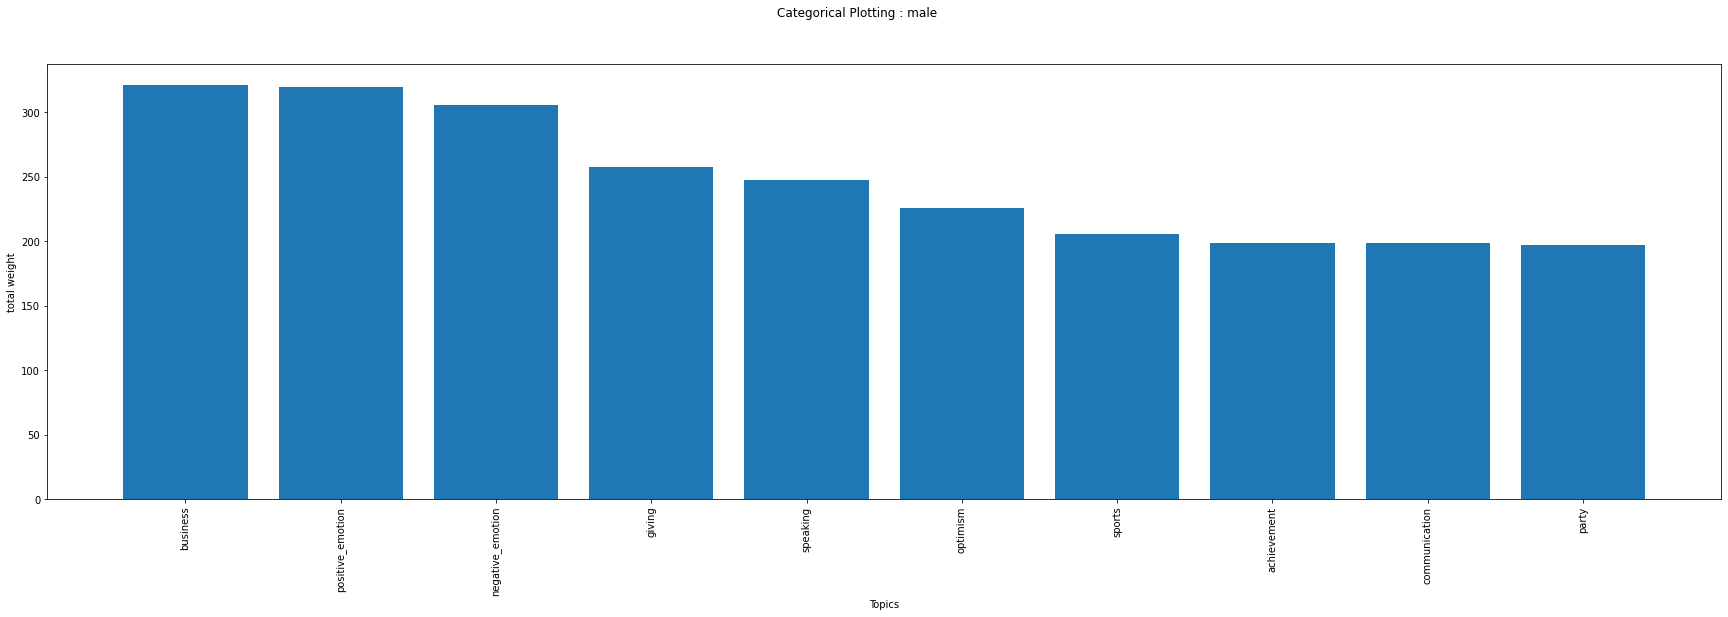

In [13]:
n_most_males_2020 = get_n_most_cited(dict_topics_males_2020, 10)
categorical_plot(n_most_males_2020, 'male')

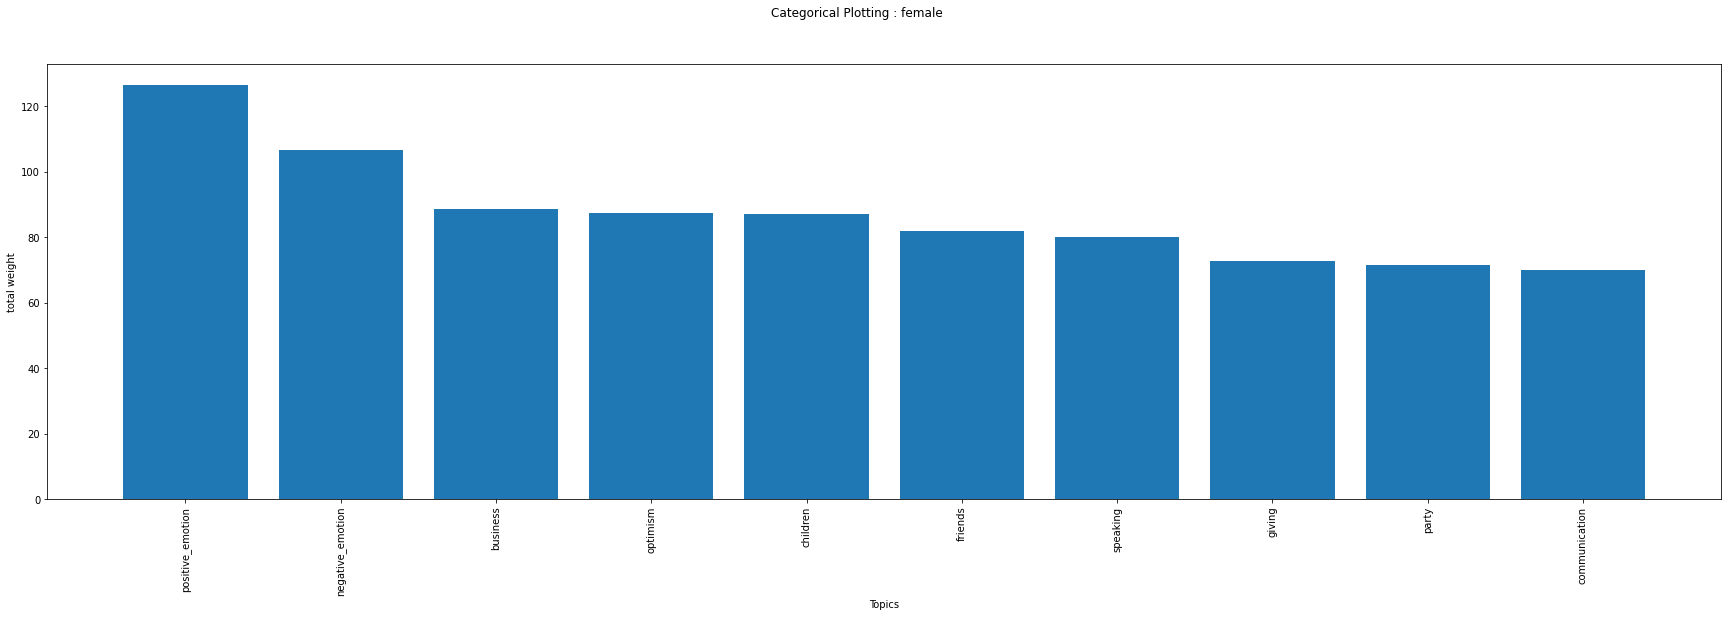

In [14]:
n_most_females_2020 = get_n_most_cited(dict_topics_females_2020, 10)
categorical_plot(n_most_females_2020, 'female')

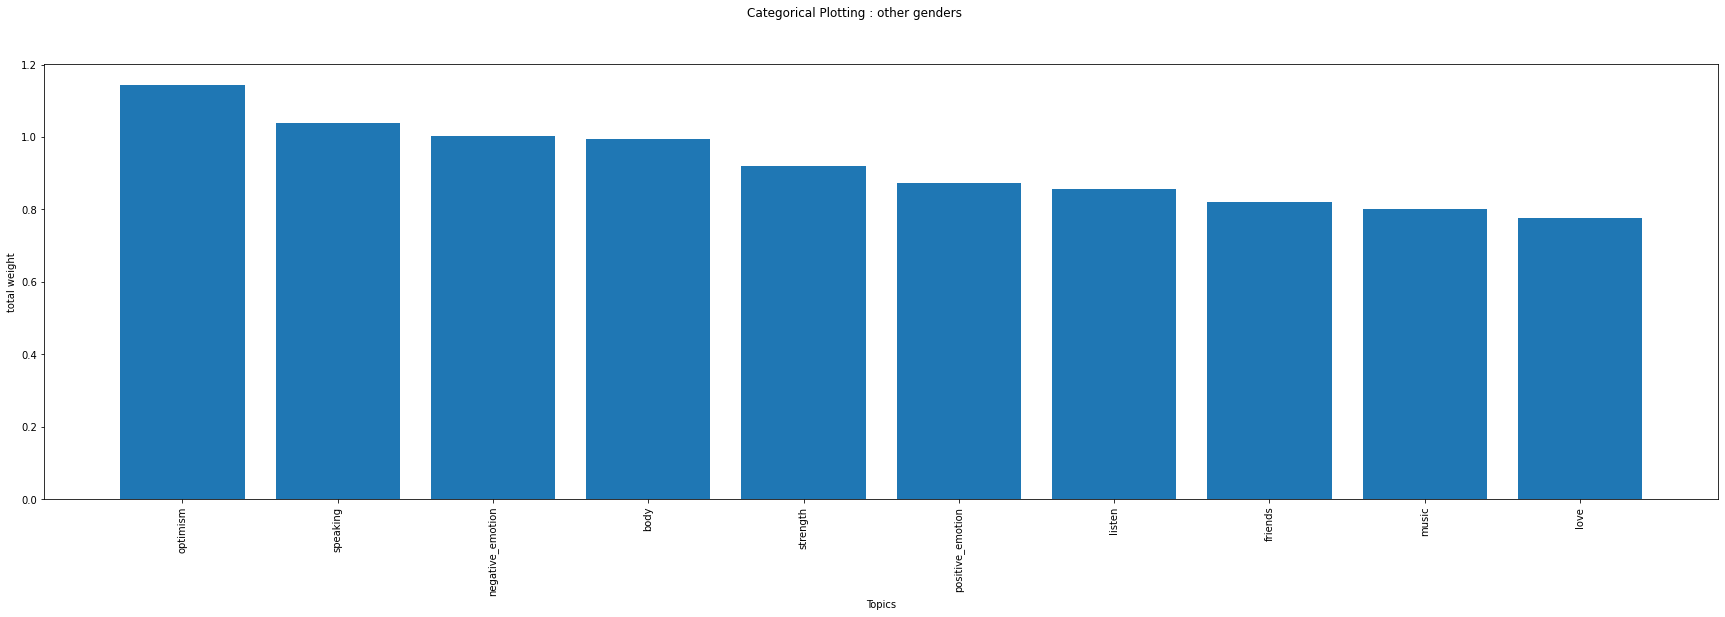

In [15]:
n_most_others_2020 = get_n_most_cited(dict_topics_others_2020, 10)
categorical_plot(n_most_others_2020, 'other genders')

In [16]:
n_most_2020 = [n_most_males_2020, n_most_females_2020, n_most_others_2020]
genders = ['Male', 'Female', 'Other genders']

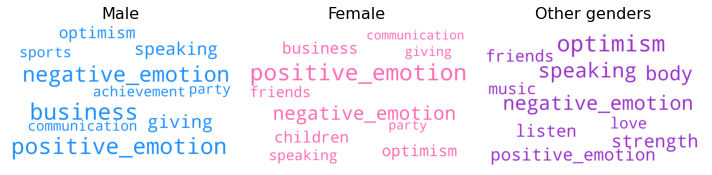

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['dodgerblue', 'hotpink', 'darkorchid']
fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

cloud = WordCloud(width=3000,
                  height=1900,
                  prefer_horizontal=1.0,
                  max_words=10,
                  background_color='white',
                  relative_scaling = 1,
                  color_func=lambda *args, **kwargs: cols[i])

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = n_most_2020[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(genders[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

2019

In [18]:
topics_2019_df = pd.read_pickle('Data with topics/QUOTES_TOPICS_2019.pkl')
# Create one topic dictionary per gender
dict_topics_males_2019 = topics_2019_df[topics_2019_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2019 = topics_2019_df[topics_2019_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2019 = topics_2019_df[topics_2019_df['gender'] == 'others'].topics.values[0]
n_most_males_2019 = get_n_most_cited(dict_topics_males_2019, 10)
n_most_females_2019 = get_n_most_cited(dict_topics_females_2019, 10)
n_most_others_2019 = get_n_most_cited(dict_topics_others_2019, 10)

2018

In [26]:
topics_2018_df = pd.read_pickle('Data with topics/QUOTES_TOPICS_2018')
# Create one topic dictionary per gender
dict_topics_males_2018 = topics_2018_df[topics_2018_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2018 = topics_2018_df[topics_2018_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2018 = topics_2018_df[topics_2018_df['gender'] == 'others'].topics.values[0]
n_most_males_2018 = get_n_most_cited(dict_topics_males_2018, 10)
n_most_females_2018 = get_n_most_cited(dict_topics_females_2018, 10)
n_most_others_2018 = get_n_most_cited(dict_topics_others_2018, 10)

2016

In [19]:
topics_2016_df = pd.read_pickle('Data with topics/QUOTES_TOPICS_2016.pkl')
# Create one topic dictionary per gender
dict_topics_males_2016 = topics_2016_df[topics_2016_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2016 = topics_2016_df[topics_2016_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2016 = topics_2016_df[topics_2016_df['gender'] == 'others'].topics.values[0]
n_most_males_2016 = get_n_most_cited(dict_topics_males_2016, 10)
n_most_females_2016 = get_n_most_cited(dict_topics_females_2016, 10)
n_most_others_2016 = get_n_most_cited(dict_topics_others_2016, 10)

2015

In [20]:
topics_2015_df = pd.read_pickle('Data with topics/QUOTES_TOPICS_2015.pkl')
# Create one topic dictionary per gender
dict_topics_males_2015 = topics_2015_df[topics_2015_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2015 = topics_2015_df[topics_2015_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2015 = topics_2015_df[topics_2015_df['gender'] == 'others'].topics.values[0]
n_most_males_2015 = get_n_most_cited(dict_topics_males_2015, 10)
n_most_females_2015 = get_n_most_cited(dict_topics_females_2015, 10)
n_most_others_2015 = get_n_most_cited(dict_topics_others_2015, 10)

We create a dataframe merging all values of the most cited topics for each year

In [39]:
def get_dict_year(dict_males,dict_females,dict_others,year):
  male_df = pd.DataFrame.from_dict(dict_males, orient='index', columns=['weight'])
  male_df['gender'] = 'male'
  female_df = pd.DataFrame.from_dict(dict_females, orient='index', columns=['weight'])
  female_df['gender'] = 'female'
  other_df = pd.DataFrame.from_dict(dict_others, orient='index', columns=['weight'])
  other_df['gender'] = 'others'
  all_df = pd.concat([male_df, female_df,other_df], axis=0)
  all_df['year'] = year
  return all_df

In [40]:
all_df_2020 = get_dict_year(n_most_males_2020,n_most_females_2020,n_most_others_2020,2020)
all_df_2019 = get_dict_year(n_most_males_2019,n_most_females_2019,n_most_others_2019,2019)
all_df_2018 = get_dict_year(n_most_males_2018,n_most_females_2018,n_most_others_2018,2018)
all_df_2016 = get_dict_year(n_most_males_2016,n_most_females_2016,n_most_others_2016,2016)
all_df_2015 = get_dict_year(n_most_males_2015,n_most_females_2015,n_most_others_2015,2015)
all_years_df = pd.concat([all_df_2020, all_df_2019,all_df_2016,all_df_2015], axis=0)
all_years_df.shape

(120, 3)

In [35]:
n_most_females_2015

{'business': 31.93197131271212,
 'children': 29.873687871441394,
 'communication': 24.73112527296258,
 'friends': 27.247989167679744,
 'giving': 25.68636968559453,
 'negative_emotion': 37.65243705414718,
 'optimism': 32.62833835114904,
 'party': 24.306765851722282,
 'positive_emotion': 38.50808428891062,
 'speaking': 28.626389948763904}

In [44]:
all_years_df[all_years_df.year == 2016].head()

,weight,gender,year
positive_emotion,471.297505,male,2016
negative_emotion,437.839880,male,2016
business,395.259201,male,2016
optimism,362.159082,male,2016
achievement,360.514067,male,2016


In [62]:
pd.unique(all_years_df.index.values)


array(['business', 'positive_emotion', 'negative_emotion', 'giving',
       'speaking', 'optimism', 'sports', 'achievement', 'communication',
       'party', 'children', 'friends', 'body', 'strength', 'listen',
       'music', 'love', 'play', 'violence', 'pain', 'family', 'money',
       'emotional', 'affection', 'heroic', 'feminine'], dtype=object)

Plots

In [80]:
x = pd.unique(all_years_df.index.values)

y = all_years_df[all_years_df.year == 2015]

y1 = y[y.gender=='male']['weight']
y2 = y[y.gender=='female']['weight']
y3 = y[y.gender=='others']['weight']

fig = go.Figure(go.Bar(x=x, y=y1, name='male'))
fig.add_trace(go.Bar(x=x, y=y2, name='female'))
fig.add_trace(go.Bar(x=x, y=y3, name='other'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title="Total weight distribution of topics per gender in 2015",
                  xaxis_title="Topics", yaxis_title="Total weights",)
fig.show()

In [81]:
x = pd.unique(all_years_df.index.values)

y = all_years_df[all_years_df.year == 2020]

y1 = y[y.gender=='male']['weight']
y2 = y[y.gender=='female']['weight']
y3 = y[y.gender=='others']['weight']

fig = go.Figure(go.Bar(x=x, y=y1, name='male'))
fig.add_trace(go.Bar(x=x, y=y2, name='female'))
fig.add_trace(go.Bar(x=x, y=y3, name='other'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title="Total weight distribution of topics per gender in 2020",
                  xaxis_title="Topics", yaxis_title="Total weights",)
fig.show()

Now let's see the mean distribution over all years

In [102]:
all_years_df['topic'] = all_years_df.index
tmp_df = all_years_df.groupby(['topic','gender'],as_index=False).sum().drop(columns=['year'])
tmp_df.head()

,topic,gender,weight
0,achievement,male,912.579295
1,affection,others,1.097473
2,body,others,1.906902
3,business,female,297.672051
4,business,male,1158.070714


In [124]:
x = pd.unique(tmp_df.topic)

y = tmp_df.copy()
y1 = y[y.gender=='male']['weight']
y2 = y[y.gender=='female']['weight']
y3 = y[y.gender=='others']['weight']

fig = go.Figure(go.Bar(x=x, y=y1, name='male'))
fig.add_trace(go.Bar(x=x, y=y2, name='female'))
fig.add_trace(go.Bar(x=x, y=y3, name='other'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title="Total weight distribution of topics per gender over all years",
                  xaxis_title="Topics", yaxis_title="Total weights")
fig.show()

In [126]:
year_df = all_years_df.groupby(['topic','gender','year'],as_index=False).sum()
female_quotes = year_df[year_df.gender == 'female']

fig = px.line(female_quotes, x='year', y='weight', color='topic', title="Evolution of most popular topics among women between 2015 and 2020")
fig.show()

In [130]:
male_quotes = year_df[year_df.gender == 'male']

fig = px.line(male_quotes, x='year', y='weight', color='topic', title="Evolution of most popular topics among men between 2015 and 2020")
fig.show()

In [140]:
year_df[year_df.gender == 'others']['weight'] != 0


4      True
5      True
6      True
15     True
20     True
21     True
25     True
26     True
27     True
29     True
34     True
35     True
36     True
37     True
46     True
47     True
49     True
50     True
51     True
52     True
53     True
54     True
63     True
64     True
65     True
66     True
75     True
76     True
77     True
78     True
79     True
99     True
100    True
101    True
102    True
111    True
112    True
117    True
118    True
119    True
Name: weight, dtype: bool

In [141]:
others_quotes = year_df[year_df.gender == 'others']

fig = px.line(others_quotes, x='year', y='weight', color='topic', title="Evolution of most popular topics among gender minorities between 2015 and 2020")
fig.show()